In [2]:
import os
import numpy as np
from tqdm import tqdm
from timeit import default_timer
import matplotlib.pyplot as plt
import argparse
import yaml
import xarray as xr

import torch
from torch.utils.data import DataLoader, random_split
from utils import *

from dataset import *
from metrics import *
import sys
import csv

## 绘图：201901不同深度预测结果

In [28]:
# test 201901 - 绘图
# test_loader中为25个月份的每月数据
def plot_temperature_at_depth(pred, i, latitude=[0, 0], longitude=[0, 0], vmin=2, vmax=10):
    """
    绘制特定深度的海水温度图，并固定颜色刻度范围。
    
    参数：
    - pred: 3D numpy 数组，大小为 [depth, lat, lon]，表示温度数据
    - i: 整数，表示要绘制的深度索引
    - vmin: 最小温度值，颜色刻度的下限
    - vmax: 最大温度值，颜色刻度的上限
    
    返回：
    - 绘制指定深度的温度分布图
    """
    # 检查深度索引是否在范围内
    if i < 0 or i >= pred.shape[0]:
        raise ValueError(f"深度索引 i 超出范围，应在 0 到 {pred.shape[0] - 1} 之间")
    
    # 获取指定深度的温度数据
    temperature_at_depth = pred[i, :, :]
    
    # 生成经纬度坐标（假设纬度范围 -90 到 90，经度范围 0 到 360）
    if np.sum(latitude) == 0:
        latitudes = np.linspace(-90, 90, temperature_at_depth.shape[0])
        longitudes = np.linspace(0, 360, temperature_at_depth.shape[1])

    # 绘制温度图
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(longitudes, latitudes, temperature_at_depth, shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Temperature Distribution at Depth Level {i}')
    plt.show()

def predict(args, i):
    """
    pred: [1, depth, lat, lon]
    """

    # get data
    train_data, test_data = get_dataset(args)
    _, _, test_loader = get_loader(train_data, test_data, args)
    data = list(test_loader)[-1]  # 取201901的数据来预测
    inputs = data[0]
    targets = data[1]
    mask = data[2]
    lat, lon = data[3], data[4]
    print('load: ', inputs.shape, targets.shape)

    # get model
    model = get_model(test_loader, args)
    model_name = args['model']['model_name']
    saved_model_name = args["challenge_name"] + '_' + args['dataset']['region_name'] + '_' + model_name
    saved_path = os.path.join(args['saved_dir'], saved_model_name)
    print(f"Test mode, load checkpoint from {saved_path}-best.pt")
    checkpoint = torch.load(saved_path + "-best.pt")
    model.load_state_dict(checkpoint["model_state_dict"])

    # pred
    model.eval()
    k = args['model']['out_dim']
    metric_names=['MSE', 'RMSE', 'MaxError','NRMSE', 'R2']
    res, pred, info = model.train_one_step(inputs, targets, mask, lat, calculate_res, k, metric_names)

    # inminmax
    # minmax
    label_min = torch.tensor([-22.1688, -10.7299,  -6.7963,  -4.5278,  -5.1864,  -5.3361,  -5.2669,
         -5.3840,  -5.5155,  -5.6514,  -5.7799,  -5.7644,  -0.9412,  -0.7708,
         -0.7653])
    label_max = torch.tensor([12.5135,  5.7999,  2.7736,  2.4664,  2.4894,  1.3013,  1.1822,  1.1807,
         1.5135,  1.5618,  1.5975,  1.5667,  1.5419,  1.4785,  1.3738])
    label_min = label_min.view(-1, 1, 1).to(pred.dtype)
    label_max = label_max.view(-1, 1, 1).to(pred.dtype)
    pred_minmax = pred[0, ...] * (label_max - label_min) + label_min
    
    # plot
    # plot_temperature_at_depth(pred_minmax.detach().numpy(), i)

    return pred[0, ...].detach().numpy(), pred_minmax.detach().numpy(), res, targets.detach().numpy()


In [34]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/config/ST_Gulf_UNET.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
pred1, pred2, res, targets = predict(args, 0)

{'challenge_name': 'T', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 10, 'plot_interval': 1, 'device': 'cuda:6', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 0}, 'dataloader': {'train_bs': 5, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'UNET', 'in_dim': 10, 'out_dim': 15, 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout': 0.0, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}
Shape of variables: torch.Size([288, 10, 54, 100]) torch.Size([288, 15, 54, 100]) torch.Size([54])

In [35]:
print(pred1.shape, pred2.shape)
print(res)

(15, 54, 100) (15, 54, 100)
{'MSE': tensor([[[0.0006, 0.0004, 0.0001, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003,
          0.0006, 0.0013, 0.0017, 0.0019, 0.0017, 0.0008, 0.0004]]],
       grad_fn=<DivBackward0>), 'RMSE': tensor([[[0.0239, 0.0207, 0.0119, 0.0191, 0.0187, 0.0185, 0.0172, 0.0182,
          0.0250, 0.0367, 0.0407, 0.0431, 0.0414, 0.0274, 0.0204]]],
       grad_fn=<SqrtBackward0>), 'MaxError': tensor([[[0.1057, 0.0870, 0.0503, 0.1011, 0.1002, 0.1080, 0.1207, 0.1331,
          0.1700, 0.2397, 0.2529, 0.2531, 0.2319, 0.1366, 0.0956]]],
       grad_fn=<MaxBackward0>), 'NRMSE': tensor([[[0.0568, 0.0477, 0.0205, 0.0359, 0.0354, 0.0429, 0.0402, 0.0443,
          0.0477, 0.0595, 0.0779, 0.0792, 0.0752, 0.0559, 0.0330]]],
       grad_fn=<DivBackward0>), 'R2': tensor([[[0.9865, 0.9900, 0.9983, 0.9931, 0.9935, 0.9888, 0.9905, 0.9882,
          0.9861, 0.9781, 0.9609, 0.9608, 0.9664, 0.9845, 0.9952]]],
       grad_fn=<RsubBackward1>)}


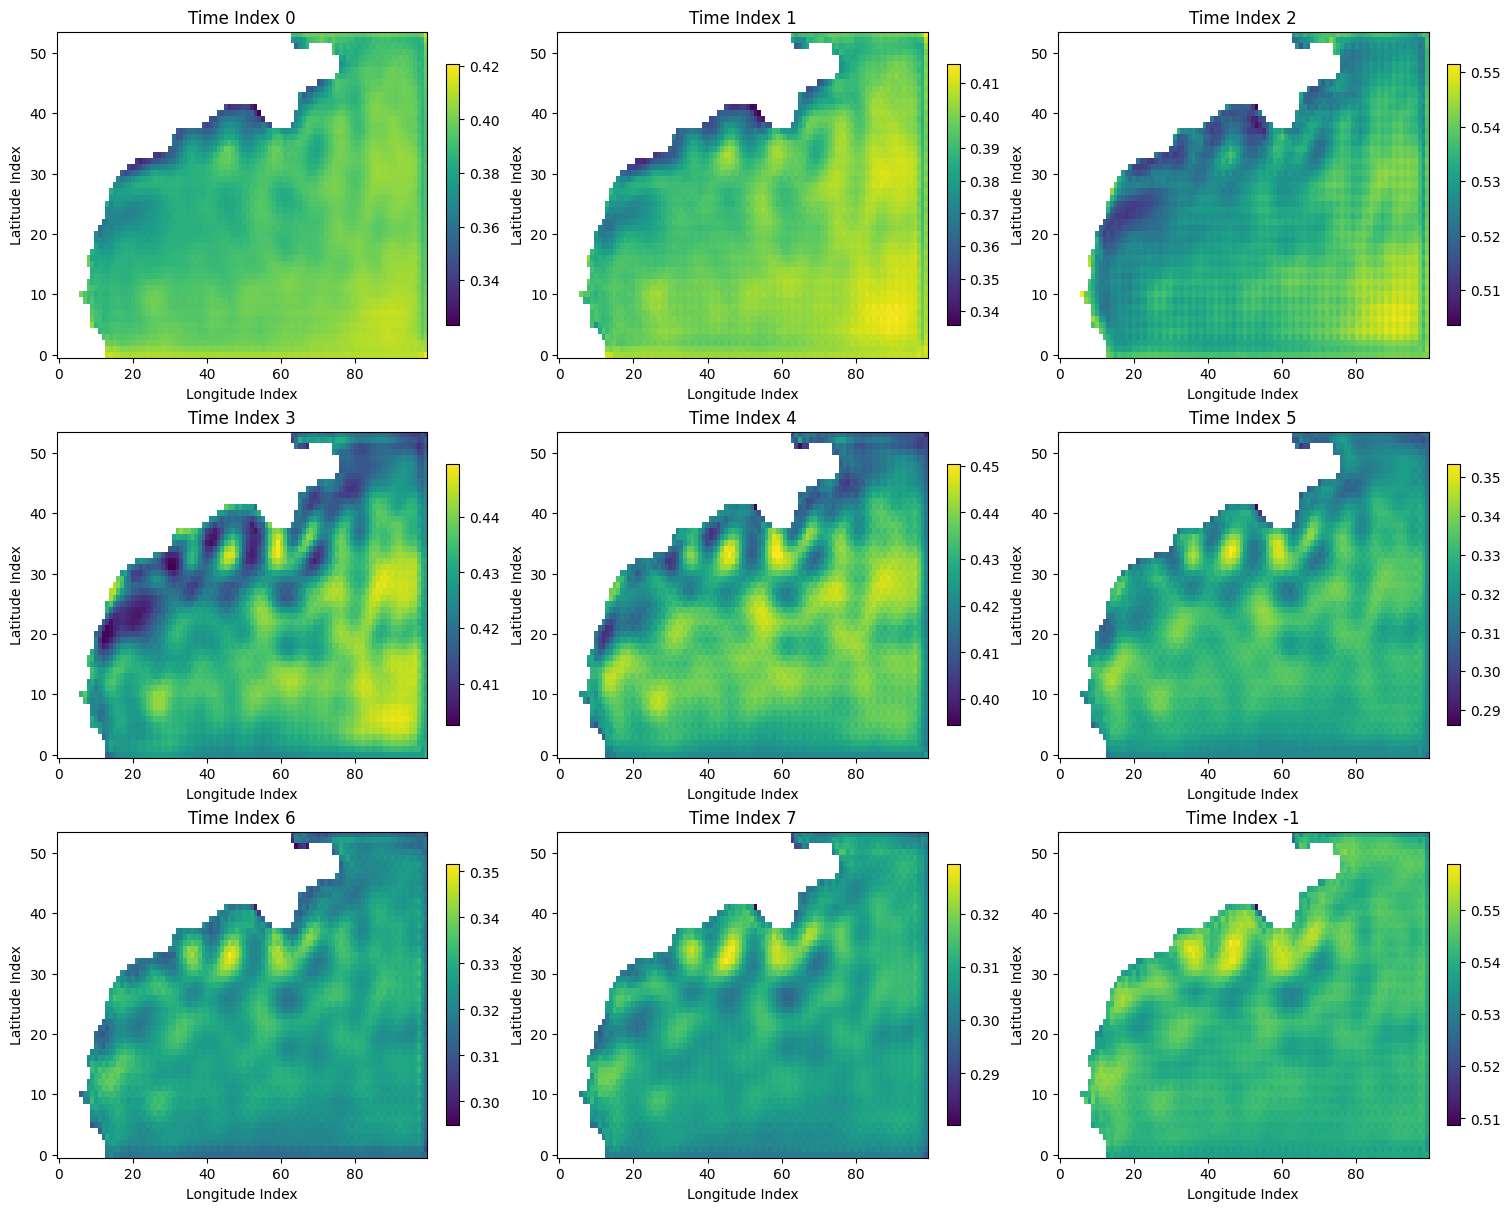

In [36]:
def plot_multiple_ocean_data(data, indices):
    """
    绘制多个时刻的海洋数据子图。

    参数:
    - data: 海洋数据的三维数组，形状为(112, 120, 280)
    - indices: 要绘制的时刻索引列表（从0开始）

    返回:
    - 绘制的多个子图。
    """
    num_plots = len(indices)
    cols = min(num_plots, 3)  # 每行最多绘制3个子图
    rows = (num_plots + cols - 1) // cols  # 计算总行数

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)
    axes = axes.flatten()  # 将子图数组展平，方便索引

    for idx, time_idx in enumerate(indices):
        time_data = data[time_idx, :, :]
        ax = axes[idx]
        im = ax.imshow(time_data, cmap='viridis', origin='lower', aspect='auto')  # ,  vmin=vmin, vmax=vmax
        ax.set_title(f'Time Index {time_idx}')
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')
        plt.colorbar(im, ax=ax, shrink=0.8)

    # 如果子图数量小于网格中的子图数量，隐藏多余的子图
    for idx in range(num_plots, len(axes)):
        axes[idx].axis('off')

    plt.show()
plot_multiple_ocean_data(pred1, [0, 1, 2, 3, 4, 5, 6, 7, -1])

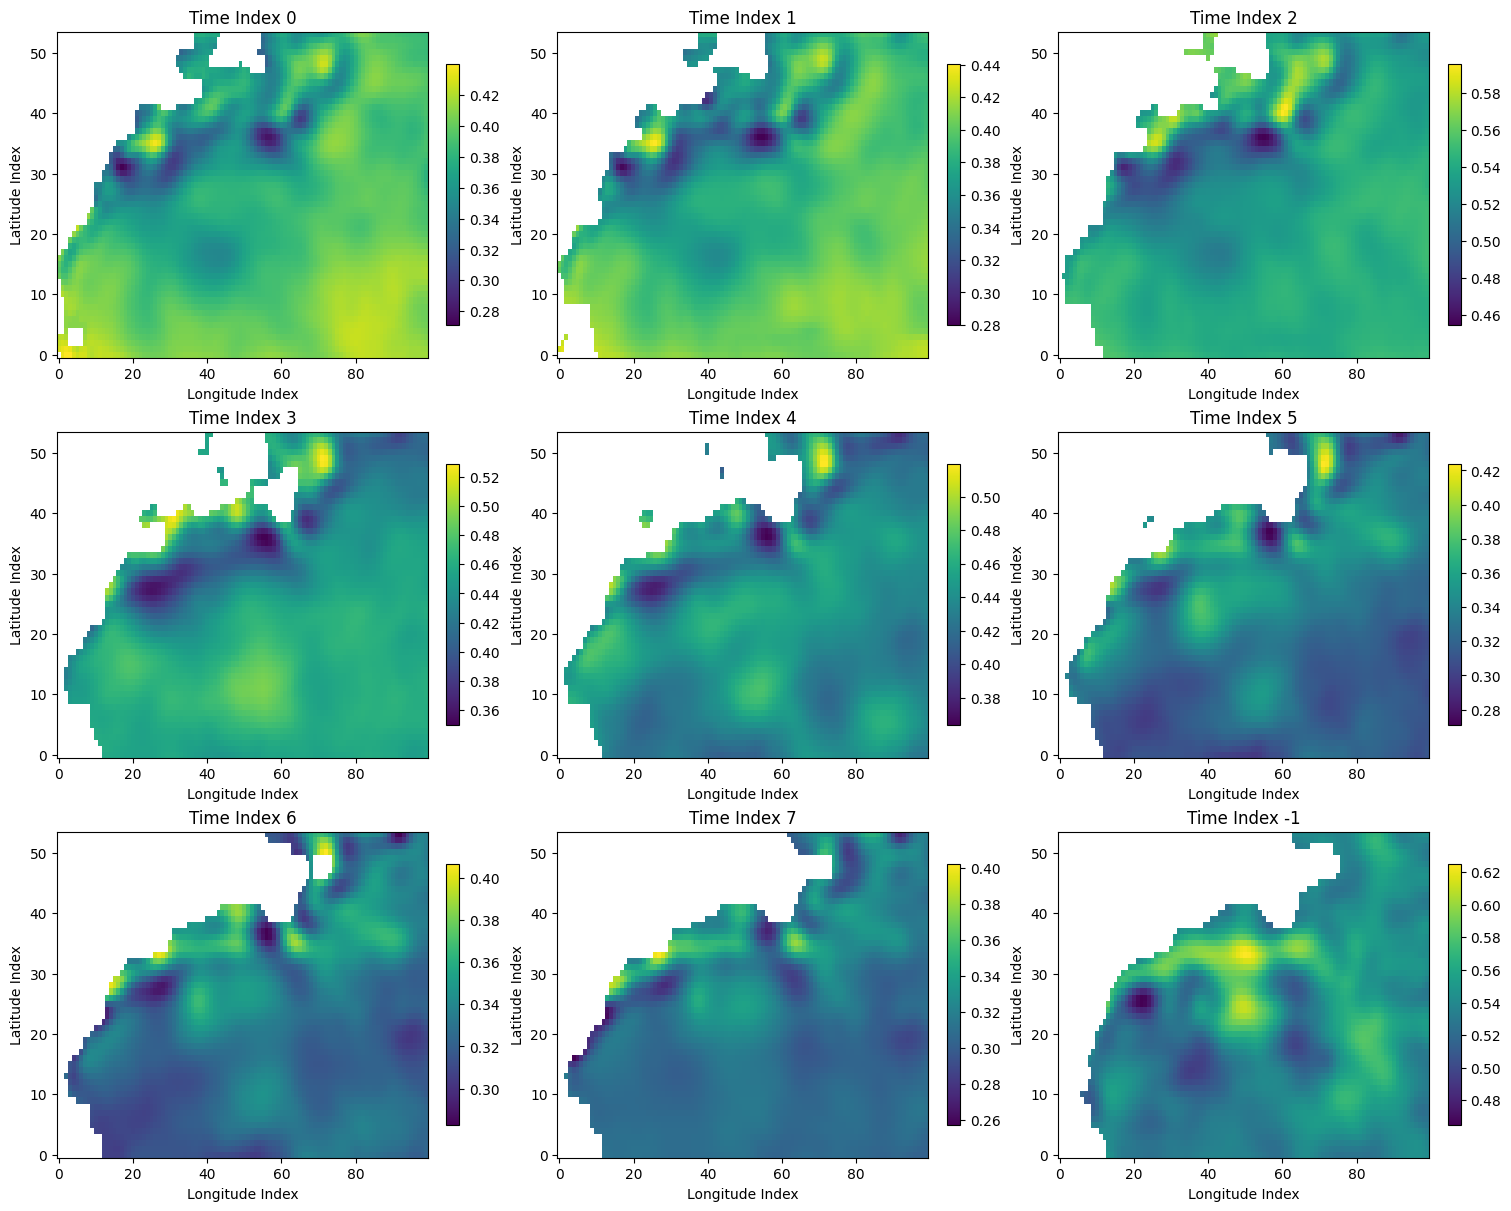

In [33]:
plot_multiple_ocean_data(targets[0, 0, ...], [0, 1, 2, 3, 4, 5, 6, 7, -1])

In [4]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/config/ST_Gulf_Earthformer.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
predict(args)

{'challenge_name': 'S', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 10, 'plot_interval': 1, 'device': 'cuda:6', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 5}, 'dataloader': {'train_bs': 2, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'Earthformer', 'in_dim': 10, 'out_dim': 15, 'base_units': 64, 'downsample_scale': [1, 2, 2], 'activ': 'Sigmoid', 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout_fraction': 0.2, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}
Shape of vari

/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 15, 54, 100])


In [5]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/config/ST_Gulf_LSTM.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
predict(args)

{'challenge_name': 'S', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 10, 'plot_interval': 1, 'device': 'cuda:6', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 5}, 'dataloader': {'train_bs': 5, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'LSTM', 'in_dim': 10, 'out_dim': 15, 'n_units1': 1000, 'n_units2': 1000, 'activ': 'Sigmoid', 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout_fraction': 0.2, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}


Shape of variables: torch.Size([283, 5, 10, 54, 100]) torch.Size([283, 1, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
Shape of variables: torch.Size([25, 5, 10, 54, 100]) torch.Size([25, 1, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
LSTM
load LSTM, in_dim=54000, out_dim=81000
Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data/S_Gulf_LSTM-best.pt
torch.Size([1, 15, 54, 100])


In [6]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/config/ST_Gulf_UNET.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
predict(args)

{'challenge_name': 'S', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 10, 'plot_interval': 1, 'device': 'cuda:6', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 0}, 'dataloader': {'train_bs': 5, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'UNET', 'in_dim': 10, 'out_dim': 15, 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout': 0.0, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}


Shape of variables: torch.Size([288, 10, 54, 100]) torch.Size([288, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
Shape of variables: torch.Size([25, 10, 54, 100]) torch.Size([25, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
UNET
load UNET, in_dim=10, out_dim=15
Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data/S_Gulf_UNET-best.pt
torch.Size([1, 15, 54, 100])


## 绘图：201901不同深度误差图

In [15]:
def plot_depth(pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, target, lat, lon):
    """
    计算2019年1月每个深度的某个地点的真实及预测值，并绘图

    pred: torch.Size([36, 54, 100])
    target: torch.Size([36, 54, 100])

    plot
    """
    pred_earthformer = pred_earthformer[:, lat, lon].numpy()
    pred_unet = pred_unet[:, lat, lon].numpy()
    pred_earthformer_new = pred_earthformer_new[:, lat, lon].numpy()
    pred_earthformer_kan = pred_earthformer_kan[:, lat, lon].numpy()
    target = target[:, lat, lon].numpy()  # [depth]

    depth = [   1.,   10.,   30.,   70.,  100.,  150.,  200.,  300.,  400.,  500.,
         600.,  700.,  800.,  900., 1000.]
    depth = [-x for x in depth]
    

    # Sample data for demonstration (replace this with actual data)
    unet = pred_unet
    earthformer = pred_earthformer
    truth = target
    new = pred_earthformer_new
    kan = pred_earthformer_kan
    

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plotting all cases (replace with your actual data)
    # def plot_nitrate_profile(ax, title):
    print(truth, unet, earthformer)
    ax.plot(truth, depth, label="truth", linestyle='--', color='black')
    ax.plot(unet, depth, label="UNet", color='#736bba')
    ax.plot(earthformer, depth, label="Earthformer", color='#7edace')
    ax.plot(new, depth, label="New_Earthformer", color='#d5dca2')
    ax.plot(kan, depth, label="Kan_Earthformer", color='#86b47a')

    ax.legend()
    
    ax.set_xscale('log')
    ax.set_xlabel('Nitrate Concentration (mmol/m³)')
    ax.set_ylabel("Depth (m)")
    ax.set_title("(a)")

    ax.set_xlim([4.7, 5.5])
    ax.set_ylim([-1000, 0])
    ax.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

[5.1437054 5.140394  5.1405907 5.149822  5.1618843 5.1587048 5.159624
 5.165642  5.158947  5.1536217 5.1522465 5.1510067 5.1487045 5.1468506
 5.1457634 5.1447773 5.1442833 5.1452713 5.14723   5.1487656 5.149782
 5.150654  5.151207  5.1519337 5.151287  5.1521893] [5.094858  5.113779  5.13517   5.314184  5.311533  5.3514442 5.149704
 5.1409264 5.1291122 5.0702534 4.923481  4.9676056 5.1371803 5.2907257
 5.0207767 5.1486454 4.867573  4.9878464 5.175783  4.993841  5.2778244
 5.0992794 4.9324074 5.315798  4.834543  5.241583 ] [5.1258545 5.1908245 5.16527   5.136549  5.1311436 5.124857  5.123705
 5.137535  5.152523  5.1487656 5.155081  5.1400833 5.1368465 5.142538
 5.1560497 5.13838   5.131033  5.1623726 5.1706886 5.145281  5.130228
 5.146961  5.1458187 5.1443024 5.131304  5.1592484]


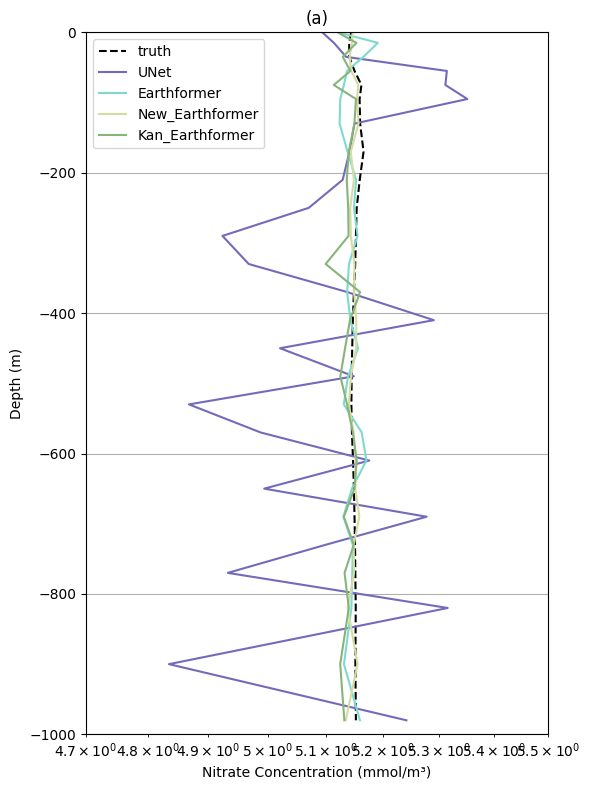

In [16]:
lat = 46
lon = 25
plot_depth(pred_unet, pred_earthformer, pred_earthformer_new, pred_earthformer_kan, target, lat, lon)

In [47]:
def plot_res(res_1, res_2, res_3, res_4, res_5, res_6, name):
    """
    计算2019年1月每个深度的某个地点的真实及预测值，并绘图

    pred: torch.Size([36])
    target: torch.Size([36])

    FNN LSTM UNET Earthformer IMLP AT_GRU

    plot
    """
    depth = [   1.,   10.,   30.,   70.,  100.,  150.,  200.,  300.,  400.,  500.,
         600.,  700.,  800.,  900., 1000.]
    depth = [-x for x in depth]
    

    # Sample data for demonstration (replace this with actual data)
    res1 = res_1
    res2 = res_2
    res3 = res_3
    res4 = res_4
    res5 = res_5
    res6 = res_6

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plotting all cases (replace with your actual data)
    # def plot_nitrate_profile(ax, title):
#     print(unet, earthformer)
    ax.plot(res1, depth, label="FNN", color='#736bba')
    ax.plot(res2, depth, label="LSTM", color='#7edace')
    ax.plot(res3, depth, label="UNET", color='#d5dca2')
    ax.plot(res4, depth, label="Earthformer", color='#86b47a')
    ax.plot(res5, depth, label="IMLP", color='#a753a1')
    ax.plot(res6, depth, label="AT_GRU", color='black')

    ax.legend()
    
    ax.set_xscale('log')
    ax.set_xlabel(name)
    ax.set_ylabel("Depth (m)")
    ax.set_title("(a)")

    ax.set_xlim([0, 0.3])
    ax.set_ylim([-1000, 0])
    ax.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [62]:
import ast

# 读取 CSV 文件路径
file_path = "/home/pengguohang/python_test/Ocean/OceanBench2/results_Pacific.csv"

# 读取 CSV 文件（假设有标题行）
data = pd.read_csv(file_path)

# 初始化结果存储字典
result = {}

# 遍历 CSV 文件内容
for _, row in data.iterrows():
    model_name = row['Model Name']
    metric = row['Metric Name']
    average_value = float(row['Average Value'])
    
    try:
        depth_values = ast.literal_eval(row['Depth Values'])  # 尝试解析深度值
    except (ValueError, SyntaxError):
        depth_values = None  # 如果解析失败，跳过

    # 检查模型是否已在结果字典中
    if model_name not in result:
        result[model_name] = {}  # 初始化模型条目

    # 添加指标数据
    result[model_name][metric] = {
        "Average Value": average_value,
        "Depth Values": depth_values
    }

# 打印解析结果
for model, metrics in result.items():
    print(f"Model: {model}")
    for metric, values in metrics.items():
        print(f"  Metric: {metric}")
        print(f"    Average Value: {values['Average Value']}")
        print(f"    Depth Values: {values['Depth Values']}")


Model: FNN
  Metric: MSE
    Average Value: 4.352718679001555e-05
    Depth Values: [[[1.1571039976843167e-05, 4.1704290197230875e-05, 8.545975288143381e-05, 0.00010239615221507847, 8.985164458863437e-05, 0.00013494527956936508, 0.0001258825941476971, 2.7872032660525292e-05, 1.072935265256092e-05, 4.045282366860192e-06, 2.408197360637132e-06, 1.7612429701330257e-06, 5.407174739957554e-06, 5.059177510702284e-06, 3.814550609604339e-06]]]
  Metric: RMSE
    Average Value: 0.0052731623873114
    Depth Values: [[[0.0033280227798968554, 0.006356127094477415, 0.009119314141571522, 0.009972332045435905, 0.0092287827283144, 0.011123423464596272, 0.010564456693828106, 0.005103462841361761, 0.003177991835400462, 0.0019750073552131653, 0.0015085458289831877, 0.0012773838825523853, 0.002249400829896331, 0.002198196016252041, 0.0019149873405694962]]]
  Metric: MaxError
    Average Value: 0.108102262020111
    Depth Values: [[[0.026842057704925537, 0.06359261274337769, 0.09387439489364624, 0.06559473

In [63]:
res_1 = np.array(result['FNN']['NRMSE']['Average Value'])
res_2 =  np.array(result['LSTM']['NRMSE']['Average Value'])
res_3 =  np.array(result['Earthformer']['NRMSE']['Average Value'])
res_4 =  np.array(result['UNET']['NRMSE']['Average Value'])
res_5 =  np.array(result['MLPE']['NRMSE']['Average Value'])
print(res_5)
res_6 =  np.array(result['AT_GRU']['NRMSE']['Average Value'])
print(res_6)

0.0153035288676619
0.1485148966312408


In [64]:
res_1 = np.array(result['FNN']['NRMSE']['Depth Values'][0][0])
res_2 =  np.array(result['LSTM']['NRMSE']['Depth Values'][0][0])
res_3 =  np.array(result['Earthformer']['NRMSE']['Depth Values'][0][0])
res_4 =  np.array(result['UNET']['NRMSE']['Depth Values'][0][0])
res_5 =  np.array(result['MLPE']['NRMSE']['Depth Values'][0][0])
print(res_5)
res_6 =  np.array(result['AT_GRU']['NRMSE']['Depth Values'][0][0])
print(res_6)

[0.01142287 0.01526884 0.02004287 0.02077339 0.02011497 0.02493743
 0.0242028  0.01706887 0.01409022 0.01388846 0.01380196 0.01383677
 0.00690552 0.00692362 0.00627434]
[0.13661848 0.1399107  0.13551569 0.14747179 0.14142798 0.11912091
 0.11541948 0.11017951 0.11298306 0.11338609 0.11250494 0.11159065
 0.23192839 0.25492033 0.24474522]


/tmp/ipykernel_1613431/3361522316.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 0.3])


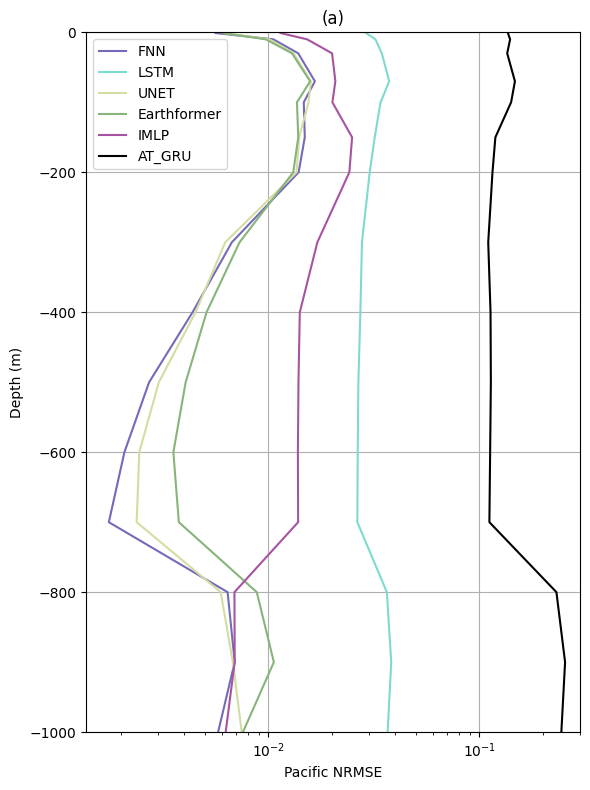

In [65]:
name = 'Pacific NRMSE'
plot_res(res_1, res_2, res_3, res_4, res_5, res_6, name)

[0.05707317 0.07230047 0.0456424  0.05298348 0.04833644 0.06143848
 0.03377931 0.05217658 0.04403264 0.04568456 0.04701978 0.05509154
 0.03136138 0.04288593 0.03222655 0.04514825 0.07218138 0.05849964
 0.03368852 0.02941938 0.0352113  0.03802916 0.04194185 0.06546923
 0.05651755 0.03491846] [0.04872776 0.0467895  0.03817562 0.03205452 0.02883623 0.02680526
 0.02417141 0.0204744  0.01788448 0.01540686 0.0138262  0.01261611
 0.01253286 0.01191592 0.01154369 0.01033578 0.01093813 0.01030877
 0.01169256 0.00829809 0.00767299 0.00734685 0.0063453  0.00634939
 0.0073942  0.00604833]


/tmp/ipykernel_314414/477330435.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 0.1])


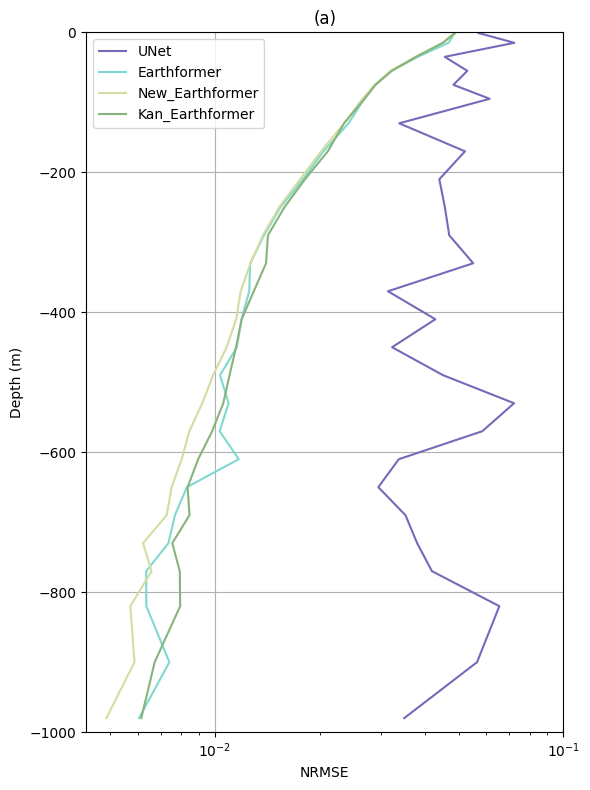

In [18]:
plot_res(res_depth_unet['NRMSE'][0], res_depth_earthformer['NRMSE'][0], res_depth_earthformer_new['NRMSE'][0], res_depth_earthformer_kan['NRMSE'][0])

## 计算春夏秋冬的误差均值

201801-03 201804-06 201807-09 201810-12

In [19]:
# UNET的误差均值
def compute_season(preds, targets, model_name):
    '''
    preds: [time, depth, lat, lon] 
    targets: [time, depth, lat, lon] 
    '''
    i = 13  # 测试集共有25个月份，从13个开始为2018年
    res = {}
    for name in ['spr', 'sum', 'aut', 'win']:
        pred = preds[i:i+3].reshape((3, 26, -1))
        target = targets[i:i+3].reshape((3, 26, -1))  # [3, depth, lat*lon]

        res_season = calculate_res(pred, target, ['MSE', 'RMSE', 'NRMSE', 'MaxError', 'R2'])
        for metric in res_season.keys():
            res_season[metric] = res_season[metric].mean()

        res[name] = res_season

        i += 3

    # Write results to CSV
    output_path = os.path.join('./', 'season_results.csv')
    with open(output_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        # Write header row
        writer.writerow([model_name, "MSE", "RMSE", "NRMSE", "MaxError", "R2"])

        # Write data for each season
        for season, metrics in res.items():
            row = [model_name, season] + [metrics[metric].item() for metric in ["MSE", "RMSE", "NRMSE", "MaxError", "R2"]]
            writer.writerow(row)


    print(f"Seasonal results written to {output_path}")
    
    return res 

In [20]:
print(len(preds_earthformer), preds_earthformer[0].shape,len(output_targets), output_targets[0].shape)

25 [1, 1, 180, 360, 26] 25 [1, 26, 180, 360]


In [21]:
# earthformer
preds = paddle.concat(preds_earthformer, axis=0)[:, 0, :, :, :].transpose((0, 3, 1, 2))

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'Earthformer')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00311832), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04557915), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01980785), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.72103014), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99952372)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00303549), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04512903), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01960697), 'MaxError': Tensor(sh

In [22]:
# earthformer_new
preds = paddle.concat(preds_earthformer_new, axis=0)[:, 0, :, :, :].transpose((0, 3, 1, 2))

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'Earthformer_new')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00300725), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04410305), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01916684), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.71012509), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99954067)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00293633), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04359984), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01894277), 'MaxError': Tensor(sh

In [23]:
# earthformer_kan
preds = paddle.concat(preds_earthformer_kan, axis=0)[:, 0, :, :, :].transpose((0, 3, 1, 2))

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'Earthformer_kan')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00311452), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04597645), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01998054), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.70920003), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99952428)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00301333), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04502665), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01956262), 'MaxError': Tensor(sh

In [24]:
# unet
preds = paddle.concat(preds_unet, axis=0)

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'UNet')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01341100), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.11201419), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04866715), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       1.58876099), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99795169)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01329639), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.11146911), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04842944), 'MaxError': Tensor(sh

## Depth

In [25]:
import xarray as xr
path = '/home/data2/pengguohang/My_Ocean/CMEMS/CORA_1993_2019_P1M/CORA_199301_201901_PSAL_P1M.nc'
ds = xr.open_dataset(path)
# label = ds['label'].values
# label_1 = label[0, ...]

# print(ds)
DEPTH = ds['depth'].values
print(DEPTH)
print(DEPTH[0:-1:4])  
# 取26个不同的深度层
# 记录下最大最小值，结果反归一化

# plot_temperature_at_depth(label_1, i=1) 

[   1.    3.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.
   55.   60.   65.   70.   75.   80.   85.   90.   95.  100.  110.  120.
  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.
  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.
  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.
  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.
  730.  740.  750.  760.  770.  780.  790.  800.  820.  840.  860.  880.
  900.  920.  940.  960.  980. 1000.]
[  1.  15.  35.  55.  75.  95. 130. 170. 210. 250. 290. 330. 370. 410.
 450. 490. 530. 570. 610. 650. 690. 730. 770. 820. 900. 980.]
